# In this notebook we plan paths for multiple agents on the hybrid graph and animate the result.

In [23]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, gate, box_2d_center
from panav.hybrid import HybridGraph
from panav.viz import draw_env,draw_hybrid

import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def flowtime(plan):
    return np.sum([t[-1] for t,x in plan])

## Single-tunnel environment

In [29]:


# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 15,-15
start_x_offset = 15
goal_x_offset = start_x_offset + 2
N = 6

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]
limits = [(-20.0,20.0),(-20.0,20.0)]


env = NavigationEnv(limits,gate(0,0,1.5,limits[1],10),starts,goals)

# Construct the hybrid graph representation of the environment
bloating_r = 0.5 
HG =  HybridGraph(env,bloating_r,K = 4)


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


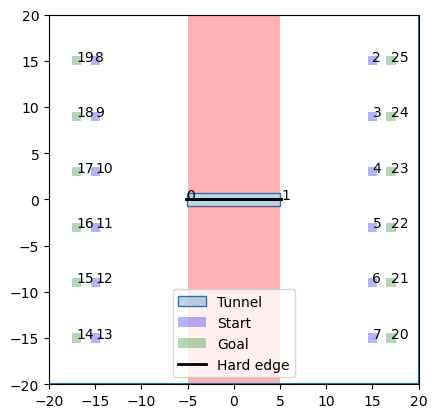

In [30]:
ax = plt.gca()
draw_hybrid(HG,ax,display_soft=False)
plt.show()    

In [31]:
from panav.HybridSIPP import HybridSIPP
from panav.SIPP import plan_to_transitions
from time import time

while True:
    agents = np.arange(len(start_locs))
    graph_plans = []
    continuous_plans = []

    success = True
    times = []
    t0 = time()
    for a in agents:
        print(a)
        result = HybridSIPP(HG,HG.start_nodes[a],HG.goal_nodes[a],graph_plans,continuous_plans)
        if result is not None:
            gp,cp = result
        else:
            print("Solver failed. Retrying...")
            success=False
            break
        graph_plans.append(gp)
        continuous_plans.append(cp)
        times.append(time()-t0)
    if success:
        print("Solution success")
        break

0
1
2
3
4
5
6
7
8
9
10
11
Solver failed. Retrying...
0
1
2
3
4
5
6
7
8
9
10
11
Solution success


In [34]:
# Save data
with open('./data/hybrid_singleTunnel.pkl','wb') as fp:
    pkl.dump({'graph_plans':graph_plans,
              'continuous_plans':continuous_plans,
              'times':times},fp)


In [40]:
# Load data
with open('./data/hybrid_singleTunnel.pkl','rb') as fp:
    data = pkl.load(fp)


In [41]:
data['times']

[0.03839373588562012,
 0.24828076362609863,
 1.2145719528198242,
 2.8281800746917725,
 4.758662939071655,
 7.112783908843994,
 10.054191827774048,
 14.798870086669922,
 22.818466901779175,
 27.645566940307617,
 33.01099491119385,
 39.42865800857544]

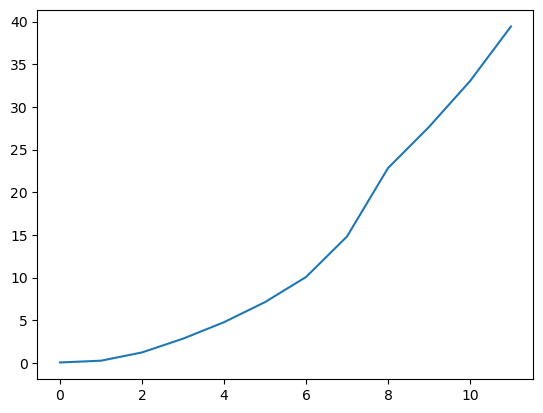

In [35]:

plt.plot(times)

# Compare with simple tube-based planning

In [36]:
from panav.SAMP import Tube_Planning
from panav.util import unique_tx
agents = set(np.arange(len(env.starts)))

plan = []
times = []
success = True
fail_time = None
for agent in agents:
    print(agent)
    
    start = env.starts[agent]
    goal = env.goals[agent]

    agent_success = False
    
    t0 = time()
    Ks = list(range(1,12))
    for K in Ks:
        print("K",K)
        results = Tube_Planning(env,start,goal,HG.vmax,bloating_r,\
                                    plan,\
                                    HG.d,K,ignore_finished_agents=False)
        if results is not None:
            t,xs = results
            times.append(time()-t0)
            print(times)
            t,xs = unique_tx(t,xs)
            plan.append((t,xs))
            agent_success = True
            break
        

    if not agent_success:
        print("Solution failed.")
        success = False
        times.append(time()-t0)
        break



0
K 1
K 2
K 3
[0.03627204895019531]
1
K 1
K 2
K 3
[0.03627204895019531, 0.06839895248413086]
2
K 1
K 2
K 3
[0.03627204895019531, 0.06839895248413086, 0.10875082015991211]
3
K 1
K 2
K 3
[0.03627204895019531, 0.06839895248413086, 0.10875082015991211, 0.14266705513000488]
4
K 1
K 2
K 3
K 4
[0.03627204895019531, 0.06839895248413086, 0.10875082015991211, 0.14266705513000488, 0.29451704025268555]
5
K 1
K 2
K 3
K 4
[0.03627204895019531, 0.06839895248413086, 0.10875082015991211, 0.14266705513000488, 0.29451704025268555, 0.4135117530822754]
6
K 1
K 2
K 3
K 4
K 5
[0.03627204895019531, 0.06839895248413086, 0.10875082015991211, 0.14266705513000488, 0.29451704025268555, 0.4135117530822754, 1.2173490524291992]
7
K 1
K 2
K 3
K 4
K 5
[0.03627204895019531, 0.06839895248413086, 0.10875082015991211, 0.14266705513000488, 0.29451704025268555, 0.4135117530822754, 1.2173490524291992, 1.6248857975006104]
8
K 1
K 2
K 3
K 4
K 5
K 6
[0.03627204895019531, 0.06839895248413086, 0.10875082015991211, 0.14266705513000

In [37]:
# Save data
with open('./data/baseline_singleTunnel.pkl','wb') as fp:
    pkl.dump({'plans':plan,
              'times':times},fp)


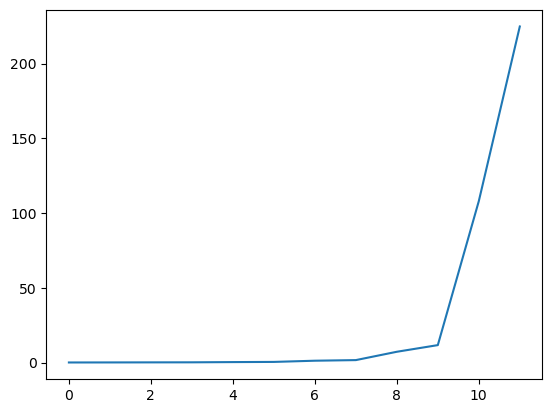

In [43]:
plt.plot(times)

In [39]:
times

[0.03627204895019531,
 0.06839895248413086,
 0.10875082015991211,
 0.14266705513000488,
 0.29451704025268555,
 0.4135117530822754,
 1.2173490524291992,
 1.6248857975006104,
 7.200000047683716,
 11.65077519416809,
 107.97080707550049,
 224.78175711631775]